<a href="https://colab.research.google.com/github/secret-key-x/sitetestgame/blob/main/%D0%9A%D0%BE%D0%BF%D1%96%D1%8F_%D0%B7%D0%B0%D0%BF%D0%B8%D1%81%D0%BD%D0%B8%D0%BA%D0%B0_%22ModuleWorkSharabura_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
from google.colab import drive
drive.mount("/content/drive")

import matplotlib.pyplot as plt
import seaborn as sns
from textblob import TextBlob
from wordcloud import WordCloud
from scipy.stats import ttest_ind

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
df = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/bda_test2.csv")

In [ ]:
year = 2008

In [ ]:
df_filtered = df.loc[
    (df['type'] == 'Movie') & (pd.to_datetime(df['release_year'], errors='coerce') == year)
]

genres = df['listed_in'].str.split(', ').explode()

genres.head()
most_common_genre = genres.mode().iloc[0]

print("Найпопулярніший жанр:", most_common_genre)

Найпопулярніший жанр: Family


In [ ]:
df_year = df[df['release_year'] == year]
type_counts = df_year['type'].value_counts()
difference = type_counts.diff().dropna().values[0]
print("Різниця (фільми - шоу):", difference)

Різниця (фільми - шоу): -17.0


In [ ]:
df_us = df_year[df_year['country'].notna()]
countries = df_us['country'].str.split(', ').explode()
us_count = countries[countries == 'United States'].count()
print("Кількість фільмів/шоу, випущених у США:", us_count)


Кількість фільмів/шоу, випущених у США: 31


In [ ]:
genres_all = df_year['listed_in'].dropna().str.split(', ').explode()
action_adventure_count = genres_all[genres_all.str.lower().str.contains("action") & genres_all.str.lower().str.contains("adventure")].count()
print("Кількість 'Екшин пригоди':", action_adventure_count)


Кількість 'Екшин пригоди': 12


In [ ]:
most_common_rating = df_year['rating'].mode().iloc[0]
print("Найпоширеніший рейтинг:", most_common_rating)


Найпоширеніший рейтинг: G


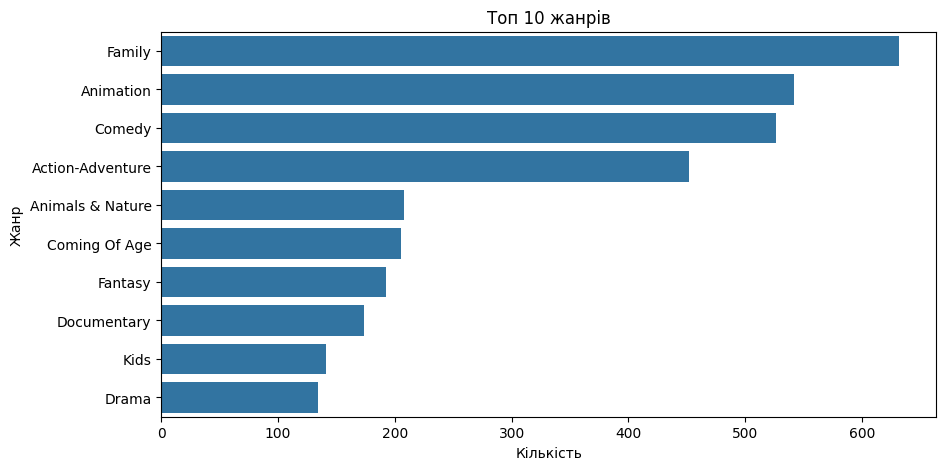

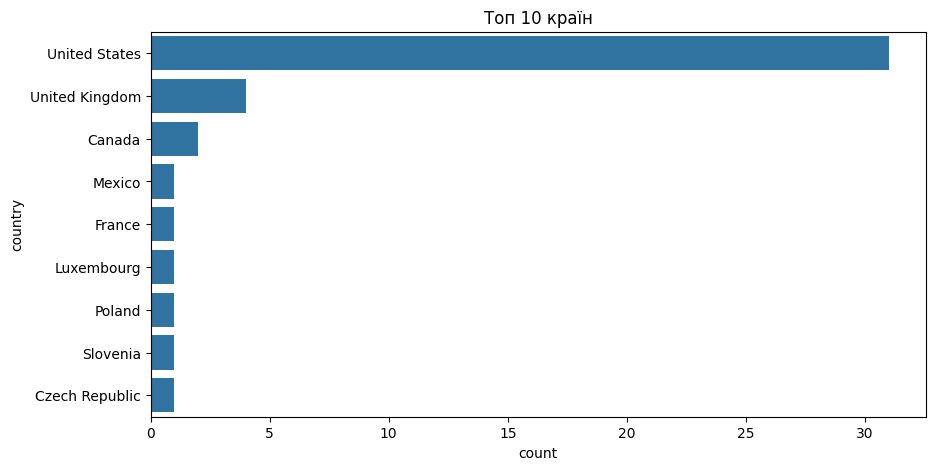

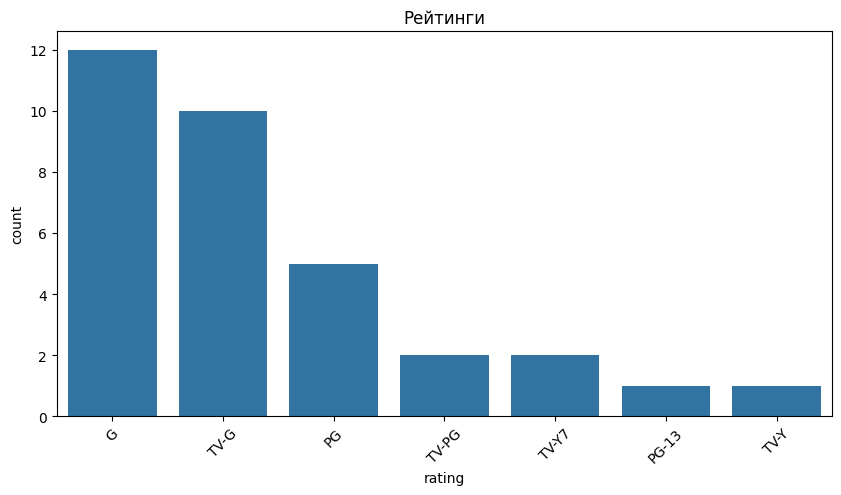

In [ ]:
genres_exploded = (
    df['listed_in']
    .dropna()
    .str.split(', ')
    .explode()
    .str.strip()
    .str.title()
    .reset_index(drop=True)
)


genre_df = pd.DataFrame({'genre': genres_exploded})

top_genres = genre_df['genre'].value_counts().head(10)

plt.figure(figsize=(10, 5))
sns.countplot(data=genre_df, y='genre', order=top_genres.index)
plt.title("Топ 10 жанрів")
plt.xlabel("Кількість")
plt.ylabel("Жанр")
plt.show()


plt.figure(figsize=(10, 5))
sns.countplot(y=df_year['country'].dropna().str.split(', ').explode(), order=df_year['country'].dropna().str.split(', ').explode().value_counts().head(10).index)
plt.title("Топ 10 країн")
plt.show()

plt.figure(figsize=(10, 5))
sns.countplot(x=df_year['rating'], order=df_year['rating'].value_counts().index)
plt.title("Рейтинги")
plt.xticks(rotation=45)
plt.show()







In [ ]:
def get_polarity(text):
    return TextBlob(str(text)).sentiment.polarity

df_year['polarity'] = df_year['description'].apply(get_polarity)

def categorize_polarity(score):
    if score > 0.1:
        return 'positive'
    elif score < -0.1:
        return 'negative'
    else:
        return 'neutral'

df_year['sentiment'] = df_year['polarity'].apply(categorize_polarity)
df_year[['description', 'polarity', 'sentiment']].head()


<ipython-input-97-4e8557846394>:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['polarity'] = df_year['description'].apply(get_polarity)
<ipython-input-97-4e8557846394>:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_year['sentiment'] = df_year['polarity'].apply(categorize_polarity)


,description,polarity,sentiment
9,Celebrate the holiday season with all your fav...,0.500000,positive
47,Disney’s favorite talking pups put one paw in ...,0.208333,positive
286,Disney Channel stars from around the globe com...,0.000000,neutral
322,Horton must save a civilization living on a sp...,0.000000,neutral
386,"Papi has to rescue his true love, Chloe, when ...",0.425000,positive


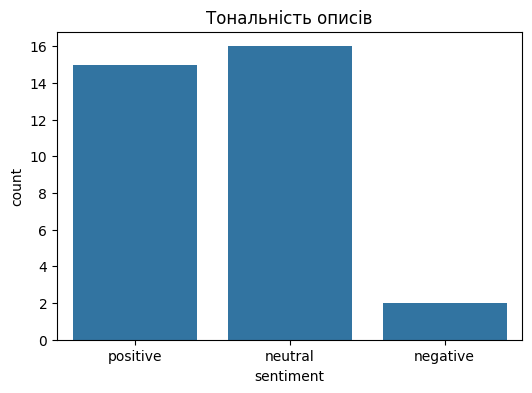

In [ ]:
plt.figure(figsize=(6, 4))
sns.countplot(x=df_year['sentiment'], order=['positive', 'neutral', 'negative'])
plt.title("Тональність описів")
plt.show()


In [ ]:
df_duration = df[df['duration'].str.contains('min', na=False)].copy()
df_duration['duration_int'] = df_duration['duration'].str.replace(' min', '').astype(int)
df_duration = df_duration.assign(genre=df_duration['listed_in'].str.split(', ')).explode('genre')
avg_duration = df_duration.groupby('genre')['duration_int'].mean()
longest_genre = avg_duration.idxmax()
print("Жанр з найдовшими фільмами:", longest_genre)


Жанр з найдовшими фільмами: Spy/Espionage


In [ ]:
df_ttest = df_duration.copy()

comedy = df_ttest[df_ttest['genre'].str.lower() == 'comedy']['duration_int']
action_adventure = df_ttest[df_ttest['genre'].str.lower().isin(['action', 'adventure'])]['duration_int']

# T-test
t_stat, p_value = ttest_ind(comedy, action_adventure, equal_var=False, nan_policy='omit')
print("T-статистика:", t_stat)
print("P-значення:", p_value)

if p_value < 0.05:
    print("Різниця статистично значуща")
else:
    print("Різниця не статистично значуща")


T-статистика: nan
P-значення: nan
Різниця не статистично значуща


/usr/local/lib/python3.11/dist-packages/scipy/_lib/deprecation.py:234: SmallSampleWarning: One or more sample arguments is too small; all returned values will be NaN. See documentation for sample size requirements.
  return f(*args, **kwargs)


In [ ]:
longest = df_duration.sort_values(by='duration_int', ascending=False).head(1)
print("Найдовший фільм:\n", longest[['title', 'duration', 'duration_int']])


Найдовший фільм:
                                   title duration  duration_int
1039  Marvel Studios' Avengers: Endgame  183 min           183


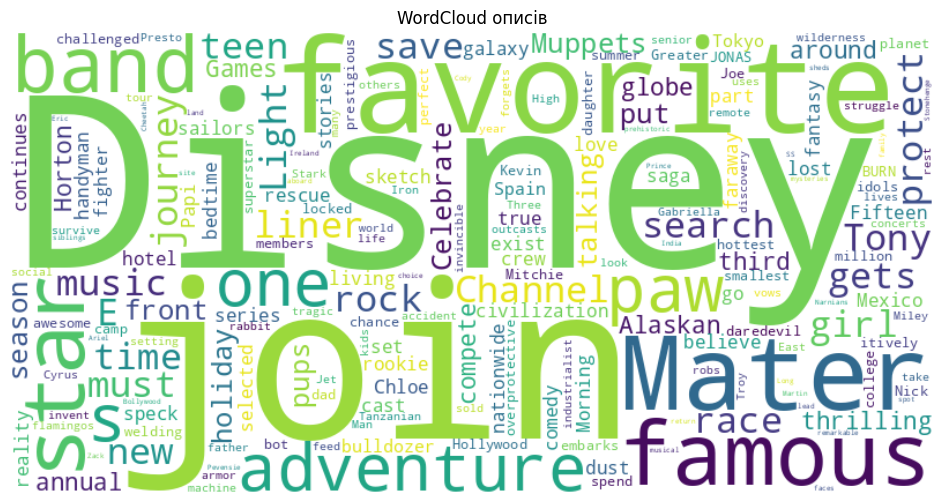

In [ ]:
text = ' '.join(df_year['description'].dropna().astype(str))

wordcloud = WordCloud(width=800, height=400, background_color='white').generate(text)

plt.figure(figsize=(12, 6))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title("WordCloud описів")
plt.show()